# Case study: catalytic asymmetric β-C–H bond activation reactions (*Digital Discovery* **2022**)

In [ ]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import VarianceThreshold

sys.path.append('../src/')
import RaRFRegressor
import utils

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14
COLORA = '#027F80'
COLORB = '#B2E5FC'



from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn


In [10]:
df1 = pd.read_excel('../data/DD_reactants.xlsx', sheet_name=None)
df2 = pd.read_excel('../data/DD_data.xlsx', sheet_name='LA-LB-LC-LD').dropna()
df2['ddG'] = utils.ee2ddg(df2[r'%ee'], df2['T (˚C)']+273.15)

df3 = pd.read_excel('../data/DD_data.xlsx', sheet_name='outofbag')
df3['ddG'] = utils.ee2ddg(df3[r'%ee'], df3['T (˚C)']+273.15)

# getting fingerprints of substances
ligands_raw = df1['ligands'].dropna()
ligands = {ligands_raw['substrate_name'][i]: utils.smi2morgan(ligands_raw['substrate_smiles'][i])
           for i in range(np.size(ligands_raw['substrate_name']))}

coupling_partners_raw = df1['coupling_partners'].dropna()
coupling_partners = {coupling_partners_raw['substrate_name'][i]:
                         utils.smi2morgan(coupling_partners_raw['substrate_smiles'][i])
                     for i in range(np.size(coupling_partners_raw['substrate_name']))}

substrates_raw = df1['substrates'].dropna()
substrates = {substrates_raw['substrate_name'][i]:
                  utils.smi2morgan(substrates_raw['substrate_smiles'][i])
              for i in range(np.size(substrates_raw['substrate_name']))}

bases_raw = df1['bases'].dropna()
bases = {bases_raw['substrate_name'][i]:
             utils.smi2morgan(bases_raw['substrate_smiles'][i])
         for i in range(np.size(bases_raw['substrate_name']))}

catalyst_raw = df1['catalyst'].dropna()
catalysts = {catalyst_raw['substrate_name'][i]: utils.smi2morgan(catalyst_raw['substrate_smiles'][i])
            for i in range(np.size(catalyst_raw['substrate_name']))}

solvent_raw = df1['solvent'].dropna()
solvents = {solvent_raw['substrate_name'][i]: utils.smi2morgan(solvent_raw['substrate_smiles'][i])
            for i in range(np.size(solvent_raw['substrate_name']))}

additive_raw = df1['additive'].dropna()
additives = {additive_raw['substrate_name'][i]: utils.smi2morgan(additive_raw['substrate_smiles'][i])
            for i in range(np.size(additive_raw['substrate_name']))}

def get_reaction_fingerprint(df):
    reaction_number = df['exp_no.']
    ddG_reactions = df[r'ddG'] # Change to ddG later
    temps = df['T (˚C)']

    substrates_reactions =[]
    for substrate in df['substrate']:
        substrates_reactions.append(substrates[substrate])

    coupling_partners_reactions =[]
    for cp in df['coupling_partner']:
        coupling_partners_reactions.append(coupling_partners[cp])

    catalysts_reactions =[]
    for cat in df['catalyst']:
        catalysts_reactions.append(catalysts[cat])

    ligands_reactions = []
    for l in df['ligand']:
        ligands_reactions.append(ligands[l])

    bases_reactions = []
    for b in df['base']:
        if pd.isnull(b):
            bases_reactions.append(np.zeros(2048))
        else:
            bases_reactions.append(bases[b])

    additives_reactions = []
    for ad in df['additive']:
        if pd.isnull(ad):
            additives_reactions.append(np.zeros(2048))
        else:
            additives_reactions.append(additives[ad])

    solvents_reactions = []
    for solv in df['solvent']:
        solvents_reactions.append(solvents[solv])

    reactions = pd.DataFrame(np.column_stack((reaction_number, ddG_reactions, temps,
                                substrates_reactions, coupling_partners_reactions, catalysts_reactions,
                                ligands_reactions, bases_reactions, additives_reactions, solvents_reactions)))
    return reactions

## Process test reactions

train_reactions = get_reaction_fingerprint(df2)
test_reactions = get_reaction_fingerprint(df3)

train_DFT = df2.iloc[:,14:-3].values

## RaRF Regression

In [11]:
results = {}
for case in ['OOB1', 'OOB2','OOB3']:
    print('case:', case)
    test_df = test_reactions[test_reactions[0] == case]
    temp_df = pd.concat([train_reactions, test_df])
    X = VarianceThreshold().fit_transform(temp_df.iloc[:,3:])
    y = temp_df.iloc[:,1]

    X_train = X[:len(train_reactions)]
    y_train = y[:len(train_reactions)]
    X_test = X[len(train_reactions):]
    y_test = y[len(train_reactions):]

    print('obtaining distances...')
    distances = utils.get_distances(X_train, X_test)
    print('distances obtained')

    test_DFT = df3[df3['exp_no.'] == case].iloc[:,14:-2].values

    for i in np.divide(range(1,10),10):
        print(f'Running RaRF with radius {i}...')

        radius_testpred, test_neighbours = RaRFRegressor.RaRFRegressor(radius=i,metric='jaccard').predict_parallel(train_DFT, y_train, test_DFT, distances)    
        nan_indexes = np.where(np.isnan(radius_testpred))[0]
            
        radius_testpred_temp = np.delete(radius_testpred,nan_indexes)
        y_test_temp = np.delete(y_test,nan_indexes)

        results[f'{case}_{i}'] = {'predictions':radius_testpred_temp, 'y_test_true':y_test_temp, 'neighbours':test_neighbours, 'temps':test_df.iloc[:,2].values,'nans':nan_indexes}
        try:
            print(f'Mean Absolute Error: {mean_absolute_error(y_test_temp, radius_testpred_temp):.2f}')
            print(f'Max observed {np.max(y_test_temp):.2f}, Max Predicted  {np.max(radius_testpred_temp):.2f}')   
            print(f'Min observed {np.min(y_test_temp):.2f}, Min Predicted  {np.min(radius_testpred_temp):.2f}')    
        except:
            pass


case: OOB1
obtaining distances...
distances obtained
Running RaRF with radius 0.1...
Running RaRF with radius 0.2...
Running RaRF with radius 0.3...
Mean Absolute Error: 0.57
Max observed 2.44, Max Predicted  1.87
Min observed 2.44, Min Predicted  1.87
Running RaRF with radius 0.4...
Mean Absolute Error: 0.35
Max observed 2.44, Max Predicted  2.00
Min observed 1.81, Min Predicted  1.82
Running RaRF with radius 0.5...
Mean Absolute Error: 0.38
Max observed 2.44, Max Predicted  1.90
Min observed 1.81, Min Predicted  1.77
Running RaRF with radius 0.6...
Mean Absolute Error: 0.42
Max observed 2.44, Max Predicted  1.87
Min observed 1.81, Min Predicted  1.74
Running RaRF with radius 0.7...
Mean Absolute Error: 0.42
Max observed 2.44, Max Predicted  1.88
Min observed 1.81, Min Predicted  1.72
Running RaRF with radius 0.8...
Mean Absolute Error: 0.41
Max observed 2.44, Max Predicted  1.95
Min observed 1.81, Min Predicted  1.73
Running RaRF with radius 0.9...
Mean Absolute Error: 0.64
Max obser

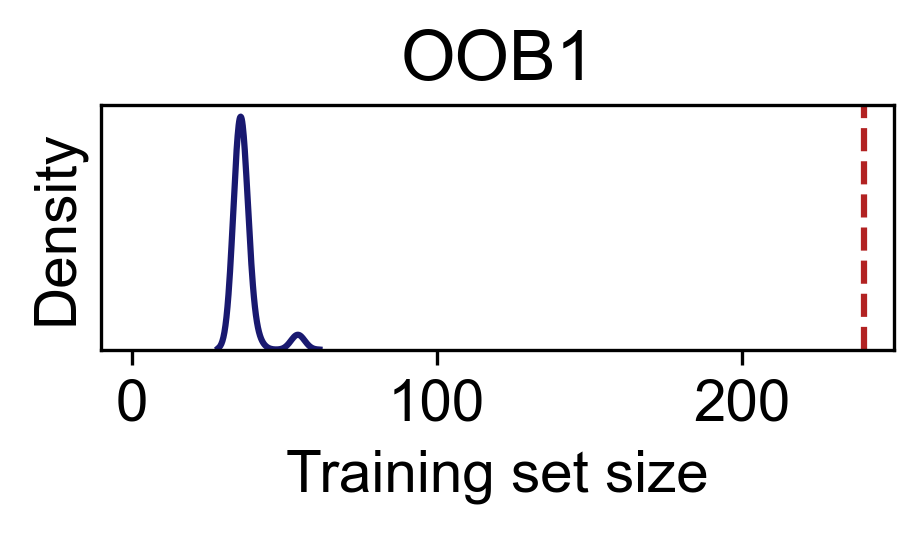

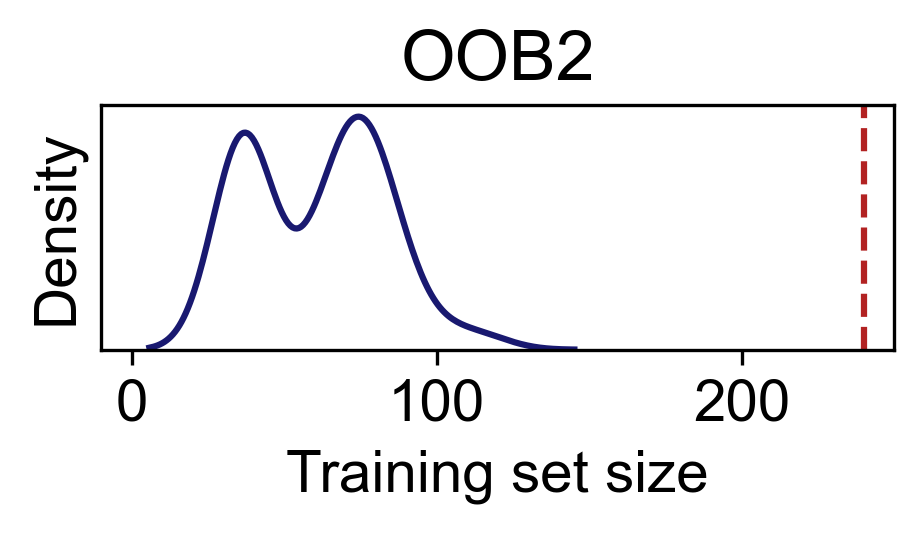

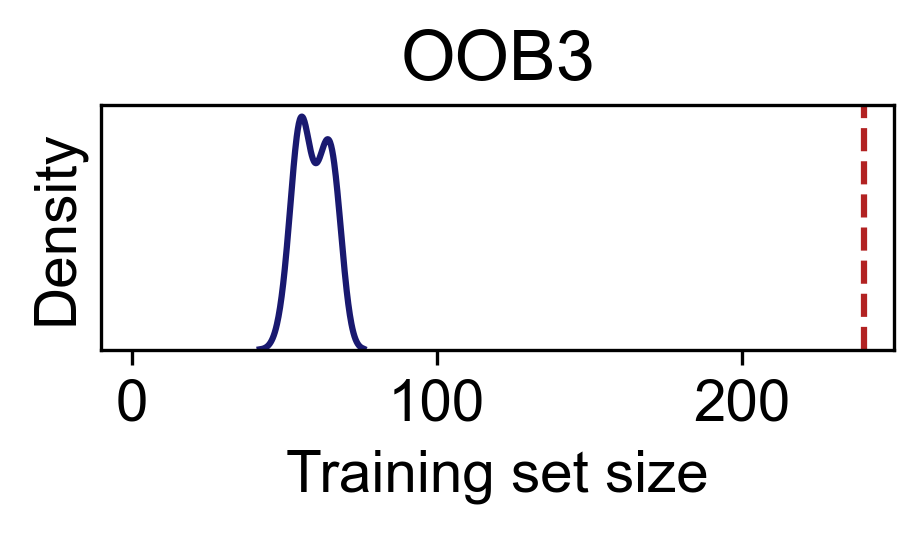

In [12]:
for test in ['OOB1','OOB2','OOB3']:
    plt.figure(figsize=(3.3,2), dpi=300)
    sns.kdeplot(results[f'{test}_0.8']['neighbours'], color='midnightblue')
    plt.xlim(-10,len(train_reactions)+10)
    plt.axvline(len(train_reactions),color='firebrick', linestyle='--')
    plt.yticks([])
    plt.xlabel('Training set size')
    plt.title(f'{test}')
    plt.tight_layout()
    plt.show()

## Deep learning - this code is from Sunoj and co-workers, Digital Discovery 2022

In [13]:
df1 = pd.read_csv('../data/DD_out-of-bag/Set-1.csv')
df1[r'%ee'] = utils.ee2ddg(df1[r'%ee'], df1['T (?C)']+273.15)  
df2 = pd.read_csv('../data/DD_out-of-bag/Set-2.csv')
df2[r'%ee'] = utils.ee2ddg(df2[r'%ee'], df2['T (?C)']+273.15)  
df3 = pd.read_csv('../data/DD_out-of-bag/Set-3.csv')
df3[r'%ee'] = utils.ee2ddg(df3[r'%ee'], df3['T (?C)']+273.15)  


df = pd.read_excel('../data/DD_data.xlsx', sheet_name='LA-LB-LC-LD').dropna()
df[r'%ee'] = utils.ee2ddg(df[r'%ee'], df['T (˚C)']+273.15)
df = df.iloc[:,14:-2]

#separate the real and synthetic dataset
Real =df.iloc[:240, :]
Synthetic =df.iloc[240:, :]


In [14]:

class NN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)      
        self.regressor = nn.Sequential(
        nn.Linear(153, 33),
        nn.ReLU(),
        nn.Linear(33,150),
        nn.ReLU(),
        nn.Linear(150,400),
        nn.ReLU(),
        nn.Linear(400,168),
        nn.ReLU(),
        nn.Linear(168,128),
        nn.ReLU(),
        nn.Linear(128, 1)

        )

    def forward(self, x):
        x = self.regressor(x)
        return x



def multNNoob(seed, df1, df2, oob1, oob2, oob3):
    df_concat=pd.concat([df1, df2], axis=0)
    feature=df_concat.iloc[:, :-1].values
    output=df_concat.iloc[:, -1].values
    
    X_test1=oob1.iloc[:, :-1].values
    y_test1=oob1.iloc[:, -1].values

    X_test2=oob2.iloc[:, :-1].values
    y_test2=oob2.iloc[:, -1].values


    X_test3=oob3.iloc[:, :-1].values
    y_test3=oob3.iloc[:, -1].values
    

    X_train, X_val, y_train, y_val=train_test_split(feature, output, test_size=0.2, random_state=0)
    #make all the tensors
    X_train=torch.FloatTensor(X_train)
    X_val=torch.FloatTensor(X_val)
    y_train=torch.FloatTensor(y_train)
    y_val=torch.FloatTensor(y_val)

    X_test1=torch.FloatTensor(X_test1)
    y_test1=torch.FloatTensor(y_test1)
    X_test2=torch.FloatTensor(X_test2)
    y_test2=torch.FloatTensor(y_test2)
    X_test3=torch.FloatTensor(X_test3)
    y_test3=torch.FloatTensor(y_test3)


    #Instantiate the model
    model=NN()
    criterion=torch.nn.MSELoss()
    optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    epoch=1000
    loss_arr=[]
    loss_val_arr=[]

    for epoch in range(epoch):
        optimizer.zero_grad()
        #Forward pass
        y_pred=model(X_train)
        #compute loss
        loss=criterion(y_pred.squeeze(), y_train)
        loss_arr.append(loss.item())
        print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
        #Backward pass
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            model.eval()
            y_pred_val=model(X_val)
            loss_val=criterion(y_pred_val.squeeze(), y_val)
            loss_val_arr.append(loss_val.item())
            print('Epoch {}: val loss: {}'.format(epoch, loss_val.item()))
    
    #Now evaluate the test set1

    y_test1_predicted=[]
    y_test1_actual=[]
    model.eval()
    y_pred1 = model(X_test1)
    y_test1_predicted.append(y_pred1.tolist())
    y_test1_actual.append(y_test1.tolist())
    print(f'OOB 1: {y_test1_predicted}')

    #Now evaluate the test set2

    y_test2_predicted=[]
    y_test2_actual=[]
    model.eval()
    y_pred2 = model(X_test2)
    y_test2_predicted.append(y_pred2.tolist())
    y_test2_actual.append(y_test2.tolist())
    print(f'OOB 2: {y_test2_predicted}')


    #Now evaluate the test set2

    y_test3_predicted=[]
    y_test3_actual=[]
    model.eval()
    y_pred3 = model(X_test3)
    y_test3_predicted.append(y_pred3.tolist())
    y_test3_actual.append(y_test3.tolist())
    print(f'OOB 3: {y_test3_predicted}')


    return y_test1_predicted, y_test2_predicted, y_test3_predicted
    

result_oob=[]
for i in range(0, 1):
    result_oob.append(multNNoob(i, Real, Synthetic, df1, df2, df3))

dfResultNormal=pd.DataFrame(result_oob, columns=['oob1','oob2','oob3' ])
dfResultNormal



Epoch 0: train loss: 11.958813667297363
Epoch 0: val loss: 23.394668579101562
Epoch 1: train loss: 22.41339111328125
Epoch 1: val loss: 2.5769245624542236
Epoch 2: train loss: 2.3355653285980225
Epoch 2: val loss: 1.8157483339309692
Epoch 3: train loss: 2.0824873447418213
Epoch 3: val loss: 3.7551872730255127
Epoch 4: train loss: 4.092147350311279
Epoch 4: val loss: 1.8672963380813599
Epoch 5: train loss: 2.1223771572113037
Epoch 5: val loss: 0.3349975645542145
Epoch 6: train loss: 0.415780633687973
Epoch 6: val loss: 0.7174122929573059
Epoch 7: train loss: 0.5836884379386902
Epoch 7: val loss: 1.239061951637268
Epoch 8: train loss: 1.0370112657546997
Epoch 8: val loss: 0.9277162551879883
Epoch 9: train loss: 0.7595541477203369
Epoch 9: val loss: 0.42049169540405273
Epoch 10: train loss: 0.34579694271087646
Epoch 10: val loss: 0.2737220525741577
Epoch 11: train loss: 0.3168318569660187
Epoch 11: val loss: 0.3725486695766449
Epoch 12: train loss: 0.4805075228214264
Epoch 12: val loss: 0

,oob1,oob2,oob3
0,"[[[1.998138427734375], [1.9099839925765991], [...","[[[2.022961378097534], [2.130866289138794], [2...","[[[3.4719552993774414], [3.564728260040283], [..."


In [15]:
oob1 = dfResultNormal['oob1'][0][0]
oob2 = dfResultNormal['oob2'][0][0]
oob3 = dfResultNormal['oob3'][0][0]

oob1 = [x[0] for x in oob1]
oob2 = [x[0] for x in oob2]
oob3 = [x[0] for x in oob3]


oob1_ee = [utils.ddg2ee(pred,temp+273.15) for pred,temp in zip(oob1,df1['T (?C)'])]
oob2_ee = [utils.ddg2ee(pred,temp+273.15) for pred,temp in zip(oob2,df2['T (?C)'])]
oob3_ee = [utils.ddg2ee(pred,temp+273.15) for pred,temp in zip(oob3,df3['T (?C)'])]

In [16]:
oob1_error = mean_absolute_error(df1[r'%ee'], oob1)
oob2_error = mean_absolute_error(df2[r'%ee'], oob2)
oob3_error = mean_absolute_error(df3[r'%ee'], oob3)

print(f'OOB1 minimum {min(oob1_ee):.2f}, maximum {max(oob1_ee):.2f}, MAE {oob1_error:.2f}')
print(f'OOB2 minimum {min(oob2_ee):.2f}, maximum {max(oob2_ee):.2f}, MAE {oob2_error:.2f}')
print(f'OOB3 minimum {min(oob3_ee):.2f}, maximum {max(oob3_ee):.2f}, MAE {oob3_error:.2f}')

OOB1 minimum 85.55, maximum 90.64, MAE 0.27
OOB2 minimum 81.30, maximum 94.02, MAE 0.22
OOB3 minimum 98.05, maximum 98.58, MAE 0.93
